Assignment Problem Statement available here: https://liangfgithub.github.io/F21/coding2.pdf

## Part II Simulation Study


#### [Part II 1. Linear Regression Full Model](#part2_1)
#### [Part II 2. Ridge Regression with $\lambda_{min}$ and $\lambda_{1se}$](#part2_2)
#### [Part II 3. Lasso Regression with $\lambda_{min}$ and $\lambda_{1se}$](#part2_3)
#### [Part II 4. Refit using Lasso $\lambda_{1se}$](#part2_4)
#### [Part II 5. Principle Component Regression with 10-fold cross validation](#part2_5)
#### [Part II 6. Simulation on BostonData2.csv](#part2_6)
#### [Part II 7. Simulation on BostonData3.csv](#part2_7)

In [ ]:
options(warn=-1)
library(glmnet)
library(pls)
set.seed(4721)

### Load Data

In [2]:
df_bsd2 = read.csv("BostonData2.csv")
df_bsd2 = df_bsd2[, -1]
dim(df_bsd2)

[1] 506  92

In [3]:
head(df_bsd2, 2)

Y,crim,zn,indus,chas,nox,rm,age,dis,rad,...,rad.tax,rad.ptratio,rad.black,rad.lstat,tax.ptratio,tax.black,tax.lstat,ptratio.black,ptratio.lstat,black.lstat
3.178054,-5.064036,1.8,0.8372475,0,-0.6198967,1.883275,3.432567,1.408545,0.0000000,...,0.000000,0.0000000,0.000000,0.000000,2.588344,22.58504,12.69856,1.805358,1.015072,8.857186
3.072693,-3.600502,0.0,1.9558605,0,-0.7571525,1.859574,5.529585,1.602836,0.6931472,...,3.804642,0.8570421,2.751101,2.095553,6.786799,21.78559,16.59439,4.907472,3.738090,11.999253


In [4]:
X_bsd2 = data.matrix(df_bsd2[,-1])  
Y_bsd2 = data.matrix(df_bsd2[,1])

#### Create id list for 50 iterations

In [5]:
T = 50
n = length(Y_bsd2)
ntest = round(n * 0.25)  # test set size
ntrain = n - ntest  # training set size
all.test.id = matrix(0, ntest, T)  # 
for(t in 1:T){
  all.test.id[, t] = sample(1:n, ntest)
}

In [6]:
all.test.id[,1]

[1] 453 210 429 424  87 394 351 407 449 126  91 194 408 401 280 266 495 107
 [19] 489 153  10 315  17 375 322 155 305 463 364 268  81 444 300 333  66 183
 [37] 292 403 264 436 211 250 252 448 298  44 412 214 209 454 291  19   8 485
 [55] 445 154 152 498 371  22 386 201 263 492   2 193 359 212  90 396  21 295
 [73]  23 377  33 171 235 272 347 502 481 317 110 490 440  12 142 427 230  71
 [91] 328 220 330 415 179  28  58 397 114  97 290  20 354 202 163 284 418  68
[109] 182 311 132  13 120 447  18 257 228 269 410 416 398 186 122 491   1  24

#### Seven Procedures

In [7]:
test.id = all.test.id[,1] 

MSPE = rep(0, 7)
names(MSPE) = c("Full", "R_min", "R_1se", "L_min", "L_1se", "L_Refit", "PCR")

trn = X_bsd2[-test.id,-1]
ytrn = Y_bsd2[-test.id]
tst = X_bsd2[test.id,-1]
ytst = Y_bsd2[test.id]

### <a id='part2_1'>Part II 1. Linear Regression Full Model</a>

In [8]:
full.model = function(trn, ytrn, tst, ytst){
    mod = lm(ytrn ~ ., data = data.frame(trn, ytrn))
    Ytest.pred = predict(mod, newdata = data.frame(tst))
    mean((ytst - Ytest.pred)^2)   
}

In [9]:
MSPE[1] = full.model(trn, ytrn, tst, ytst)

### <a id='part2_2'>Part II 2. Ridge Regression with $\lambda_{min}$ and $\lambda_{1se}$</a>

In [10]:
cv.out = cv.glmnet(X_bsd2[-test.id, ], Y_bsd2[-test.id], alpha = 0)
best.lam = cv.out$lambda.min
Ytest.pred = predict(cv.out, s = best.lam, newx = X_bsd2[test.id, ])
MSPE[2] = mean((Y_bsd2[test.id] - Ytest.pred)^2)

In [11]:
MSPE[2]

R_min 
0.03557618

In [12]:
sum(cv.out$lambda < best.lam)

[1] 0

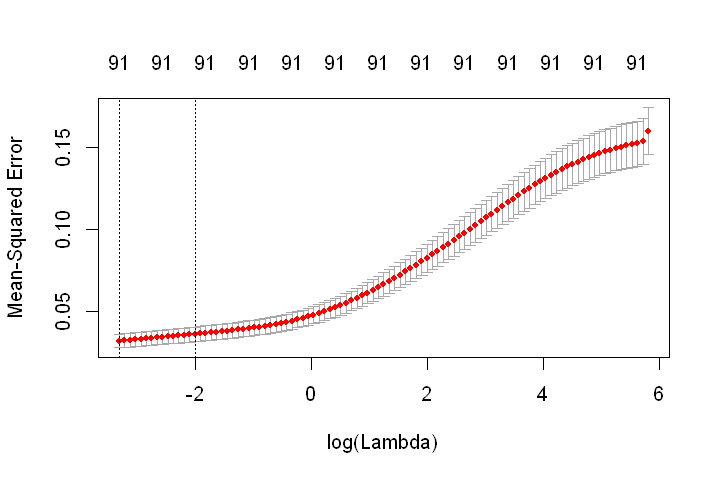

In [13]:
options(repr.plot.width=6, repr.plot.height=4)
plot(cv.out)

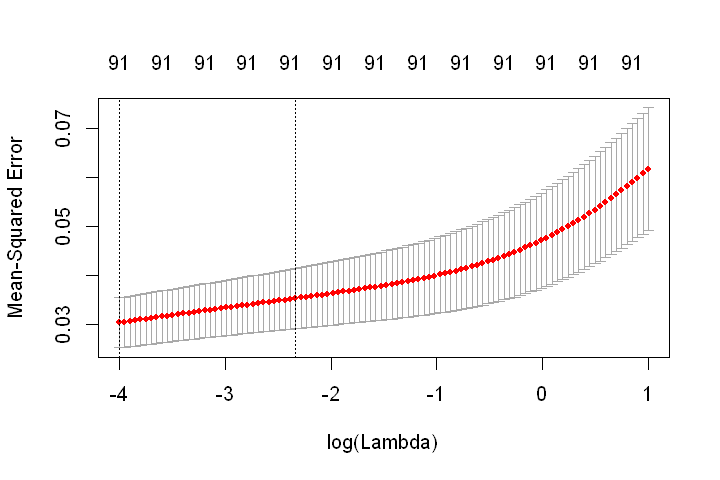

In [14]:
mylasso.lambda.seq = exp(seq(-4, 1, length.out = 100))
cv.out = cv.glmnet(X_bsd2[-test.id, ], Y_bsd2[-test.id], alpha = 0, 
                   lambda = mylasso.lambda.seq)
plot(cv.out)

In [15]:
myridge.lambda.seq = exp(seq(-10, -2, length.out = 100))
cv.out = cv.glmnet(X_bsd2[-test.id, -1], Y_bsd2[-test.id], alpha = 0, 
                   lambda = myridge.lambda.seq)

best.lam = cv.out$lambda.min
Ytest.pred = predict(cv.out, s = best.lam, newx = X_bsd2[test.id, -1])
MSPE[2] = mean((Y_bsd2[test.id] - Ytest.pred)^2)

best.lam = cv.out$lambda.1se
Ytest.pred = predict(cv.out, s = best.lam, newx = X_bsd2[test.id, -1])
MSPE[3] = mean((Y_bsd2[test.id] - Ytest.pred)^2)

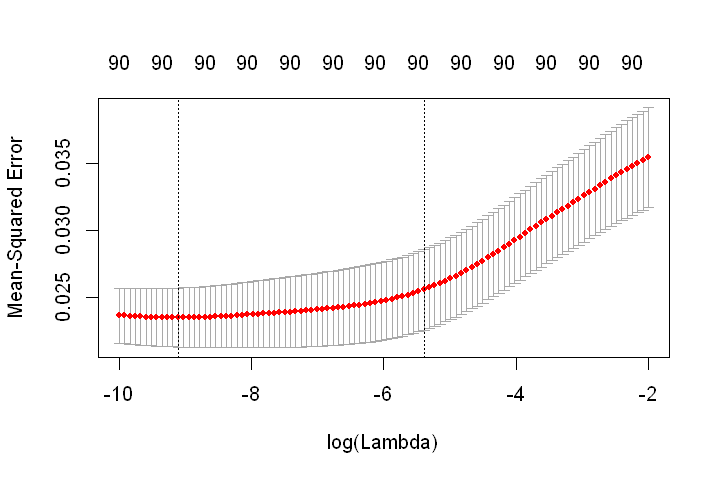

In [16]:
plot(cv.out)

> We see that the mean sqaured error has converged somewhere between -6 and -7, hence this is the lambda sequence we will use.

#### Wrapping ridge regression in function

In [17]:
ridge_reg_mod = function(trn, ytrn, tst, ytst, lambda_sequence){
    mod = cv.glmnet(trn, ytrn, alpha = 0, lambda = lambda_sequence)
    
    # using min lambda
    best.lam = mod$lambda.min
    Ytest.pred = predict(mod, s = best.lam, newx = tst)
    lam_min_MSPE = mean((ytst - Ytest.pred)^2)

    # using 1se lambda
    best.lam = mod$lambda.1se
    Ytest.pred = predict(mod, s = best.lam, newx = tst)
    lam_1se_MSPE = mean((ytst - Ytest.pred)^2)
    
    return (c(lam_min_MSPE, lam_1se_MSPE))
}

In [18]:
myridge.lambda.seq = exp(seq(-10, -2, length.out = 100))

ridge_MSPE = ridge_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
MSPE[2] = ridge_MSPE[1]
MSPE[3] = ridge_MSPE[2]

### <a id='part2_3'>Part II 3. Lasso Regression with $\lambda_{min}$ and $\lambda_{1se}$</a>
and 
### <a id='part2_3'>Part II 4. Refit using Lasso $\lambda_{1se}$</a>

In [19]:
lasso_reg_mod = function(trn, ytrn, tst, ytst, lambda_sequence){
    mod = cv.glmnet(trn, ytrn, alpha = 1, lambda = lambda_sequence)
    
    # using min lambda
    best.lam = mod$lambda.min
    Ytest.pred = predict(mod, s = best.lam, newx = tst)
    lam_min_MSPE = mean((ytst - Ytest.pred)^2)

    # using 1se lambda
    best.lam = mod$lambda.1se
    Ytest.pred = predict(mod, s = best.lam, newx = tst)
    lam_1se_MSPE = mean((ytst - Ytest.pred)^2)
    
    # refit using variables selected by lasso
    coef = predict(mod, s = best.lam, type = "coefficients")
    var.sel = row.names(coef)[which(coef != 0)[-1]]
    
    # lasso refit model    
    lasso.refit = lm(ytrn ~ ., data.frame(trn[, c(var.sel)], ytrn))
    Ytest.pred = predict(lasso.refit, newdata = data.frame(tst))
    lasso_refit_MSPE = mean((Ytest.pred - ytst)^2)
    
    return (c(lam_min_MSPE, lam_1se_MSPE, lasso_refit_MSPE))
}

In [20]:
lasso_MSPE = lasso_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
MSPE[4] = lasso_MSPE[1]
MSPE[5] = lasso_MSPE[2]
MSPE[6] = lasso_MSPE[3]

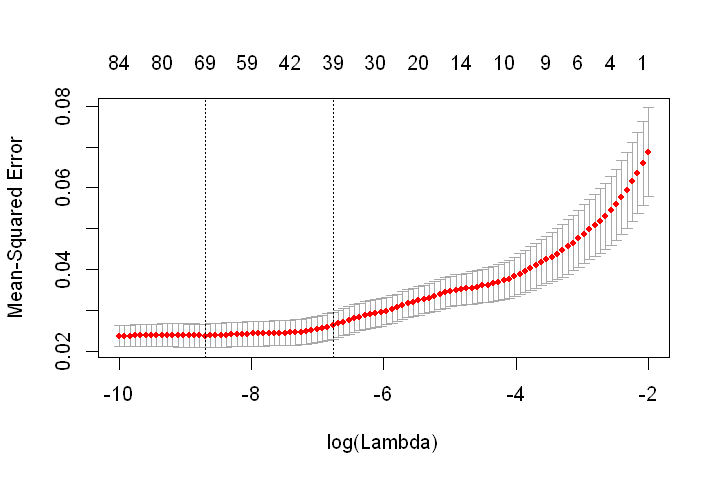

In [21]:
lasso = cv.glmnet(trn, ytrn, alpha = 1, lambda = myridge.lambda.seq)
plot(lasso)

> The above plot shows that our lambda sequence does include convergence of mean squeared error. Hence, we will be sticking withi this lambda sequence.

### <a id='part2_5'>Part II 5. Principle Component Regression with 10-fold cross validation</a>

In [22]:
pcr_mod = function(trn, ytrn, tst, ytst){
    mod = pcr(ytrn ~ ., data= data.frame(trn, ytrn), validation="CV")
    CVerr = RMSEP(mod)$val[1, , ]
    adjCVerr = RMSEP(mod)$val[2, , ]
    best.ncomp = which.min(CVerr) - 1
    
    if (best.ncomp==0) {
        Ytest.pred = mean(ytrn)
          } else {
            Ytest.pred = predict(mod, data.frame(tst), ncomp=best.ncomp)
          }
    
    return (mean((Ytest.pred - ytst)^2))
}

In [23]:
MSPE[7] = pcr_mod(trn, ytrn, tst, ytst)

### <a id='part2_6'>Part II 6. Simulation on BostonData2.csv</a>

In [24]:
bsd2_mspe = data.frame(matrix(ncol = 7, nrow = 0))
names(bsd2_mspe) = c("Full", "R_min", "R_1se", "L_min", "L_1se", "L_Refit", "PCR")

In [25]:
for (i in 1:50){
    trn = X_bsd2[-all.test.id[,i],-1]
    ytrn = Y_bsd2[-all.test.id[,i]]
    tst = X_bsd2[all.test.id[,i],-1]
    ytst = Y_bsd2[all.test.id[,i]]
    myridge.lambda.seq = exp(seq(-10, -2, length.out = 100))

    # get linear full model MSPE
    full_mod_MSPE = full.model(trn, ytrn, tst, ytst)
    
    # get ridge regression MSPE
    ridge_MSPE = ridge_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
    ridge_min_lam_MSPE = ridge_MSPE[1]
    ridge_1se_lam = ridge_MSPE[2]
    
    # get lasso regression MSPE
    lasso_MSPE = lasso_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
    ridge_min_lam_MSPE = lasso_MSPE[1]
    ridge_1se_lam = lasso_MSPE[2]
    lm_coef_by_lasso = lasso_MSPE[3]
    
    #get pcr MSPE
    pcr_mspe = pcr_mod(trn, ytrn, tst, ytst)
    
    bsd2_mspe[i, ] = (c(full_mod_MSPE, ridge_min_lam_MSPE, ridge_1se_lam, ridge_min_lam_MSPE, 
           ridge_1se_lam, lm_coef_by_lasso, pcr_mspe))
    
}

In [26]:
head(bsd2_mspe, 5)

Full,R_min,R_1se,L_min,L_1se,L_Refit,PCR
0.04053788,0.03444941,0.03316166,0.03444941,0.03316166,0.03614341,0.03864002
0.02958547,0.02394157,0.02666824,0.02394157,0.02666824,0.02780697,0.02606226
0.04396523,0.03640127,0.03676592,0.03640127,0.03676592,0.04109177,0.04296312
0.02394863,0.02671897,0.03363290,0.02671897,0.03363290,0.03140306,0.02531125
0.02802986,0.03113314,0.02690664,0.03113314,0.02690664,0.03411280,0.02763480


In [28]:
# reorder the dataframe for boxplot
bsd2_box = data.frame(matrix(ncol = 2, nrow = 0))
names(bsd2_box) = c("Method", 'MSPE')

for (col in names(bsd2_mspe)){
    bsd2_col = data.frame(rep(col, 50), bsd2_mspe[, col])
    names(bsd2_col) = c("Method", 'MSPE')
    bsd2_box = rbind(bsd2_box, bsd2_col)
}

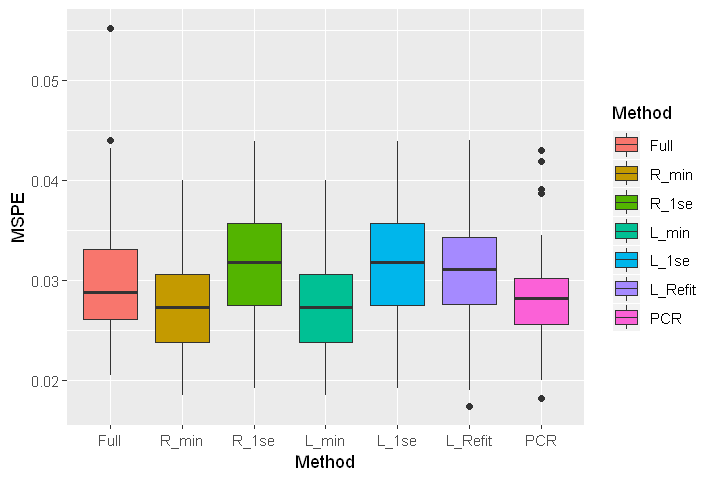

In [35]:
library('ggplot2')
ggplot(bsd2_box, aes(x = Method, y = MSPE, fill = Method)) + 
  geom_boxplot()

### <a id='part2_7'>Part II 7. Simulation on BostonData3.csv</a>

In [30]:
# load data for this simulation
df_bsd3 = read.csv("BostonData3.csv")
df_bsd3 = df_bsd3[, -1]
dim(df_bsd3)

[1] 506 592

In [31]:
head(df_bsd3,2)

Y,crim,zn,indus,chas,nox,rm,age,dis,rad,...,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
3.178054,-5.064036,1.8,0.8372475,0,-0.6198967,1.883275,3.432567,1.408545,0.0000000,...,9.311734,42.34041,-98.23702,-0.218876414,242.3782,22.91441,2.833203,-0.7315671,188.33876,5.603043
3.072693,-3.600502,0.0,1.9558605,0,-0.7571525,1.859574,5.529585,1.602836,0.6931472,...,2.483401,42.54168,-78.16123,0.006359093,230.5006,21.37800,7.343570,-0.7721275,54.12018,12.177419


In [32]:
X_bsd3 = data.matrix(df_bsd3[,-1])  
Y_bsd3 = data.matrix(df_bsd3[,1])

In [36]:
bsd3_mspe = data.frame(matrix(ncol = 6, nrow = 0))
names(bsd3_mspe) = c("R_min", "R_1se", "L_min", "L_1se", "L_Refit", "PCR")

In [37]:
for (i in 1:50){
    trn = X_bsd3[-all.test.id[,i],-1]
    ytrn = Y_bsd3[-all.test.id[,i]]
    tst = X_bsd3[all.test.id[,i],-1]
    ytst = Y_bsd3[all.test.id[,i]]
    myridge.lambda.seq = exp(seq(-10, -2, length.out = 100))
     
    # get ridge regression MSPE
    ridge_MSPE = ridge_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
    ridge_min_lam_MSPE = ridge_MSPE[1]
    ridge_1se_lam = ridge_MSPE[2]
        
    # get lasso regression MSPE
    lasso_MSPE = lasso_reg_mod(trn, ytrn, tst, ytst, myridge.lambda.seq)
    ridge_min_lam_MSPE = lasso_MSPE[1]
    ridge_1se_lam = lasso_MSPE[2]
    lm_coef_by_lasso = lasso_MSPE[3]
        
    #get pcr MSPE
    pcr_mspe = pcr_mod(trn, ytrn, tst, ytst)
    
    bsd3_mspe[i, ] = c(ridge_min_lam_MSPE, ridge_1se_lam, ridge_min_lam_MSPE, 
           ridge_1se_lam, lm_coef_by_lasso, pcr_mspe)
    
}

In [38]:
# reorder the dataframe for boxplot
bsd3_box = data.frame(matrix(ncol = 2, nrow = 0))
names(bsd3_box) = c("Method", 'MSPE')

for (col in names(bsd3_mspe)){
    bsd3_col = data.frame(rep(col, 50), bsd3_mspe[, col])
    names(bsd3_col) = c("Method", 'MSPE')
    bsd3_box = rbind(bsd3_box, bsd3_col)
}

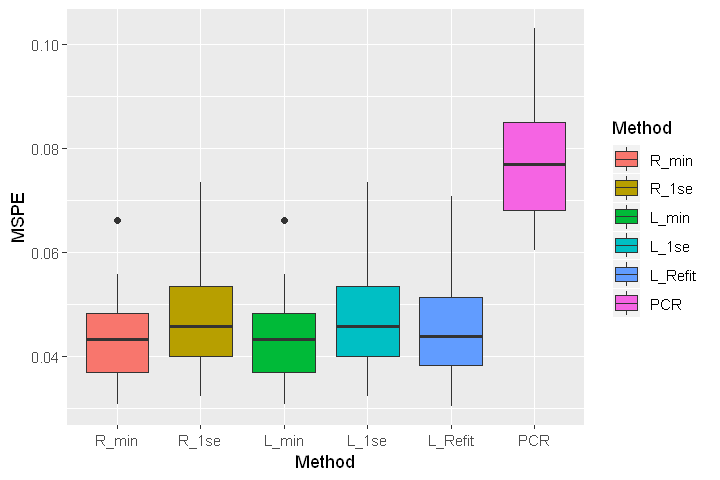

In [39]:
library('ggplot2')
ggplot(bsd3_box, aes(x = Method, y = MSPE, fill = Method)) + 
  geom_boxplot()

> Insights:

> Full model is performing worse with boston data 3 since there is multicolinearity.

> PCR works well on boston data 2 vs boston data 3.

> Mean Prediction Error of minimum lamba option is less compared to 1se lambda.